# **Anomaly Detection in Network Traffic Using Agglomerative Hierarchical Clustering**

In [2]:
import kagglehub

path = kagglehub.dataset_download("dhoogla/unswnb15")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'unswnb15' dataset.
Path to dataset files: /kaggle/input/unswnb15


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import seaborn as sns


“The UNSW-NB15 dataset is a modern network intrusion detection dataset that contains both normal network traffic and a wide variety of cyber-attacks.
Each record describes a network flow using numeric features such as packet counts, bytes transferred, durations, load, and timing information.
The dataset is widely used for machine learning research in intrusion detection, anomaly detection, and cybersecurity.”

In [4]:
df_train = pd.read_parquet("/root/.cache/kagglehub/datasets/dhoogla/unswnb15/versions/5/UNSW_NB15_training-set.parquet")
df_test = pd.read_parquet("/root/.cache/kagglehub/datasets/dhoogla/unswnb15/versions/5/UNSW_NB15_testing-set.parquet")

In [5]:
df_train

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087486,1.415894e+04,...,0,0,1,1,0,0,0,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473373,8.395112e+03,...,0,0,1,1,0,0,0,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,1.572272e+03,...,0,0,1,1,0,0,0,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,2.740179e+03,...,0,0,1,1,1,1,0,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373825,8.561499e+03,...,0,0,2,1,0,0,0,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,udp,dns,INT,2,0,114,0,111111.109375,5.066666e+07,...,0,0,24,13,0,0,0,0,Generic,1
175337,0.505762,tcp,-,FIN,10,8,620,354,33.612648,8.826286e+03,...,0,0,1,1,0,0,0,0,Shellcode,1
175338,0.000009,udp,dns,INT,2,0,114,0,111111.109375,5.066666e+07,...,0,0,3,3,0,0,0,0,Generic,1
175339,0.000009,udp,dns,INT,2,0,114,0,111111.109375,5.066666e+07,...,0,0,30,14,0,0,0,0,Generic,1


In [6]:
df_test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.093750,1.803636e+08,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000000,8.810000e+08,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.000000,8.544000e+08,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.656250,6.000000e+08,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.000000,8.504000e+08,...,0,0,2,1,0,0,0,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.000000,8.320000e+07,...,0,0,1,1,0,0,0,0,Normal,0
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,1.241044e+05,...,0,0,1,1,0,0,0,0,Normal,0
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,1,1,0,0,0,1,Normal,0
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,1,1,0,0,0,1,Normal,0


In [7]:
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

In [8]:
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087486,1.415894e+04,...,0,0,1,1,0,0,0,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473373,8.395112e+03,...,0,0,1,1,0,0,0,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,1.572272e+03,...,0,0,1,1,0,0,0,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,2.740179e+03,...,0,0,1,1,1,1,0,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373825,8.561499e+03,...,0,0,2,1,0,0,0,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000005,udp,-,INT,2,0,104,0,200000.000000,8.320000e+07,...,0,0,1,1,0,0,0,0,Normal,0
257669,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,1.241044e+05,...,0,0,1,1,0,0,0,0,Normal,0
257670,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,1,1,0,0,0,1,Normal,0
257671,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,1,1,0,0,0,1,Normal,0


In [9]:
df.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
       'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports',
       'attack_cat', 'label'],
      dtype='object')

In [20]:
features = [
    'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes',
    'rate', 'sload', 'dload', 'sloss', 'dloss',
    'sinpkt', 'dinpkt', 'sjit', 'djit',
    'swin', 'dwin', 'tcprtt', 'synack'
]

df=df.sample(n=10000,random_state=42)
X = df[features]
X = X.sample(n=10000,random_state=42)

In [21]:
X

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,dwin,tcprtt,synack
125860,0.000009,2,0,114,0,111111.109375,5.066666e+07,0.000000e+00,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
83389,0.000010,2,0,1064,0,100000.000000,4.256000e+08,0.000000e+00,0,0,0.010000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
92057,1.271346,10,8,2516,354,13.371655,1.425261e+04,1.950688e+03,2,1,139.830215,170.214722,8774.746094,247.569443,255,255,0.168342,0.079842
5985,0.088987,90,92,5174,83812,2034.005005,4.600222e+05,7.452864e+06,7,39,1.007557,0.971264,61.511059,60.590054,255,255,0.000736,0.000593
152569,0.000007,2,0,114,0,142857.140625,6.514286e+07,0.000000e+00,0,0,0.007000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72673,0.676684,14,6,6830,268,28.078098,7.498921e+04,2.648208e+03,4,1,47.446075,114.804398,3118.724121,167.813828,255,255,0.169964,0.102652
87769,0.000009,2,0,200,0,111111.109375,8.888889e+07,0.000000e+00,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
63120,1.882240,8,8,364,582,7.969228,1.355831e+03,2.167630e+03,1,2,268.759003,259.226868,19809.970703,551.821655,255,255,0.115216,0.067643
48356,0.000005,2,0,200,0,200000.000000,1.600000e+08,0.000000e+00,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000


In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


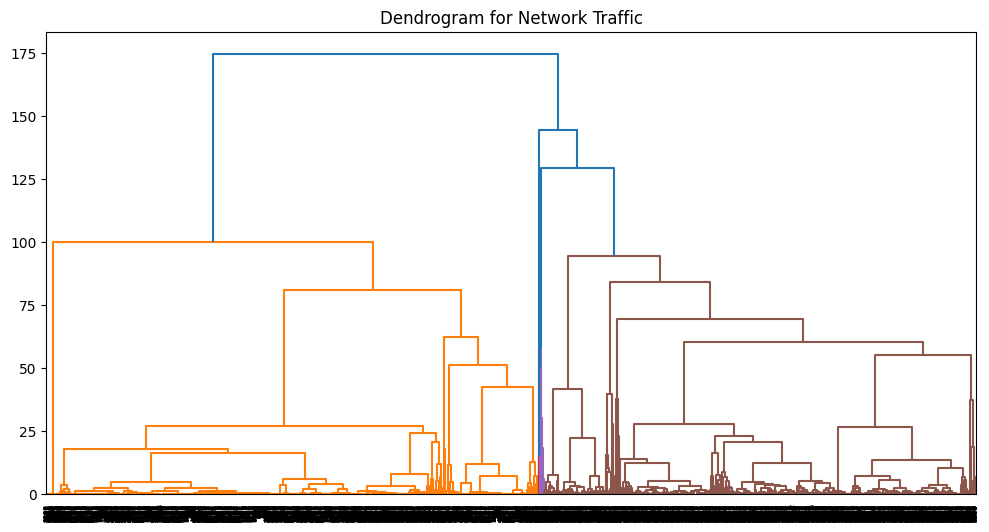

In [23]:
plt.figure(figsize=(12, 6))
plt.title("Dendrogram for Network Traffic")
dend = shc.dendrogram(shc.linkage(X_scaled[:5000], method='ward'))
plt.show()


In [24]:
n_clusters = 12  # higher clusters = better outlier isolation

hc = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward'
)

labels = hc.fit_predict(X_scaled)
df['cluster'] = labels


In [25]:
cluster_counts = df['cluster'].value_counts()
print(cluster_counts)


cluster
3     4660
2     2440
1     1871
5      364
4      306
11     146
8      145
0       40
9       16
7        7
6        4
10       1
Name: count, dtype: int64


In [26]:
rare_clusters = cluster_counts[cluster_counts < 0.02 * len(df)]
rare_clusters


,count
cluster,
11,146
8,145
0,40
9,16
7,7
6,4
10,1


In [27]:
df['is_anomaly'] = df['cluster'].isin(rare_clusters.index)


s=(b−a​)/max(a,b) ; a=average distance to points between same clusters ; b=average distance to points in the nearest different cluster

In [28]:
score = silhouette_score(X_scaled, labels)
print("Silhouette Score:", score)


Silhouette Score: 0.5558840193646339


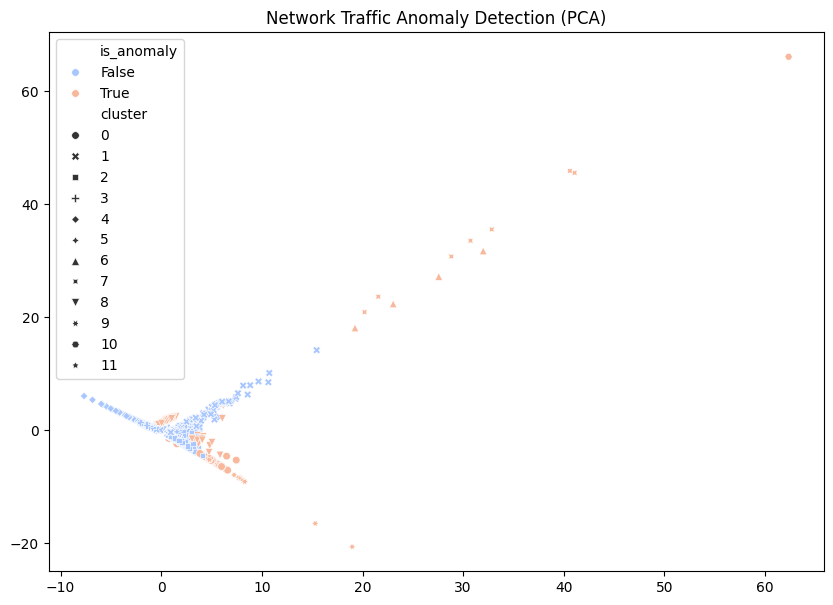

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_points = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
sns.scatterplot(
    x=pca_points[:,0],
    y=pca_points[:,1],
    hue=df['is_anomaly'],
    style=df['cluster'],
    s=30,
    palette="coolwarm"
)
plt.title("Network Traffic Anomaly Detection (PCA)")
plt.show()
